In [35]:
pip install --upgrade prophet


Note: you may need to restart the kernel to use updated packages.


In [1]:
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt

from prophet import Prophet

In [12]:
df = pd.read_csv('epl_season_1993_2024.csv')
df.tail()

,Season_End_Year,Total_Matches,Total_HomeGoals,Total_AwayGoals,Home_Wins,Away_Wins,Draws,Total_Goals,Champion,Runners
27,2020,380,576,458,172,116,92,1034,Liverpool,Manchester City
28,2021,380,514,510,144,153,83,1024,Manchester City,Manchester United
29,2022,380,575,496,163,129,88,1071,Manchester City,Liverpool
30,2023,380,621,463,184,109,87,1084,Manchester City,Arsenal
31,2024,380,684,562,175,123,82,1246,Manchester City,Arsenal


In [13]:
# Prepare the time series data for total goals per season
total_goals_series = df.set_index('Season_End_Year')['Total_Goals']

# Fit an ARIMA model (p=1, d=1, q=1 are common starting parameters, but these can be tuned)
model = ARIMA(total_goals_series, order=(1, 1, 1))
model_fit = model.fit()

# Forecast the next season (2024)
forecast_goals = model_fit.forecast(steps=1)

# Since forecast_goals is a Series, use .iloc[0] to get the first forecasted value
next_season_goals = forecast_goals.iloc[0]

# Print the forecasted total goals for the next season
next_season_year = df['Season_End_Year'].max() + 1
print(f"Forecasted total goals for the {next_season_year} season: {next_season_goals:.0f}")


Forecasted total goals for the 2025 season: 1206


/Users/pranavsrinivasvenkatesh/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/pranavsrinivasvenkatesh/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/pranavsrinivasvenkatesh/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/pranavsrinivasvenkatesh/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/pranavsrinivasvenkatesh/anaconda3

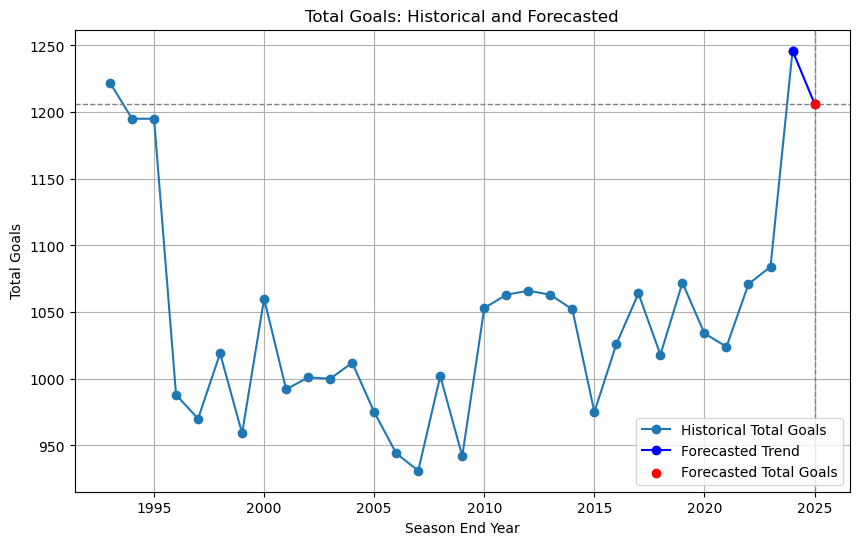

In [14]:
# Plot the historical data
plt.figure(figsize=(10, 6))
plt.plot(total_goals_series, label='Historical Total Goals', marker='o')

# Extend the line to connect the last historical point to the forecasted point
plt.plot([total_goals_series.index[-1], next_season_year], 
         [total_goals_series.iloc[-1], next_season_goals], 
         color='blue', linestyle='-', marker='o', label='Forecasted Trend')

# Highlight the forecasted point with a different color
plt.scatter([next_season_year], [next_season_goals], color='red', label='Forecasted Total Goals', zorder=5)

# Add vertical and horizontal lines for the forecasted point
plt.axvline(x=next_season_year, color='gray', linestyle='--', linewidth=1)
plt.axhline(y=next_season_goals, color='gray', linestyle='--', linewidth=1)

# Additional plot settings
plt.title('Total Goals: Historical and Forecasted')
plt.xlabel('Season End Year')
plt.ylabel('Total Goals')
plt.legend()
plt.grid(True)
plt.show()

In [15]:
print(df.info())
print(df.head())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32 entries, 0 to 31
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Season_End_Year  32 non-null     int64 
 1   Total_Matches    32 non-null     int64 
 2   Total_HomeGoals  32 non-null     int64 
 3   Total_AwayGoals  32 non-null     int64 
 4   Home_Wins        32 non-null     int64 
 5   Away_Wins        32 non-null     int64 
 6   Draws            32 non-null     int64 
 7   Total_Goals      32 non-null     int64 
 8   Champion         32 non-null     object
 9   Runners          32 non-null     object
dtypes: int64(8), object(2)
memory usage: 2.6+ KB
None
   Season_End_Year  Total_Matches  Total_HomeGoals  Total_AwayGoals  \
0             1993            462              723              499   
1             1994            462              663              532   
2             1995            462              697              498   
3             1996

In [16]:
print(df.isnull().sum())


Season_End_Year    0
Total_Matches      0
Total_HomeGoals    0
Total_AwayGoals    0
Home_Wins          0
Away_Wins          0
Draws              0
Total_Goals        0
Champion           0
Runners            0
dtype: int64


In [17]:
df['Season_End_Year'] = pd.to_datetime(df['Season_End_Year'], format='%Y')
df.head()

,Season_End_Year,Total_Matches,Total_HomeGoals,Total_AwayGoals,Home_Wins,Away_Wins,Draws,Total_Goals,Champion,Runners
0,1993-01-01,462,723,499,214,118,130,1222,Manchester United,Aston Villa
1,1994-01-01,462,663,532,192,128,142,1195,Manchester United,Blackburn Rovers
2,1995-01-01,462,697,498,205,123,134,1195,Blackburn Rovers,Manchester United
3,1996-01-01,380,580,408,186,96,98,988,Manchester United,Newcastle United
4,1997-01-01,380,559,411,162,99,119,970,Manchester United,Newcastle United


In [18]:
# Prepare the data for Prophet
df_prophet = df[['Season_End_Year', 'Total_Goals']].rename(columns={'Season_End_Year': 'ds', 'Total_Goals': 'y'})

# Initialize and fit the model
model_prophet = Prophet(yearly_seasonality=True)
model_prophet.fit(df_prophet)

# Create a future dataframe for the next season
future = model_prophet.make_future_dataframe(periods=1, freq='Y')

# Forecast
forecast_prophet = model_prophet.predict(future)

# Extract the forecasted value for the next season
next_season_goals_prophet = forecast_prophet['yhat'].iloc[-1]


16:01:27 - cmdstanpy - INFO - Chain [1] start processing
16:01:27 - cmdstanpy - INFO - Chain [1] done processing


In [19]:
# Ensure the 'Season_End_Year' column is a datetime object
df['Season_End_Year'] = pd.to_datetime(df['Season_End_Year'], format='%Y')

# Prepare the data for Prophet
df_prophet = df[['Season_End_Year', 'Total_Goals']].rename(columns={'Season_End_Year': 'ds', 'Total_Goals': 'y'})

# Initialize and fit the model
model_prophet = Prophet(yearly_seasonality=True)
model_prophet.fit(df_prophet)

# Create a future dataframe for the next season
future = model_prophet.make_future_dataframe(periods=1, freq='Y')

# Forecast
forecast_prophet = model_prophet.predict(future)

# Extract the forecasted value for the next season
next_season_goals_prophet = forecast_prophet['yhat'].iloc[-1]

16:01:29 - cmdstanpy - INFO - Chain [1] start processing
16:01:30 - cmdstanpy - INFO - Chain [1] done processing


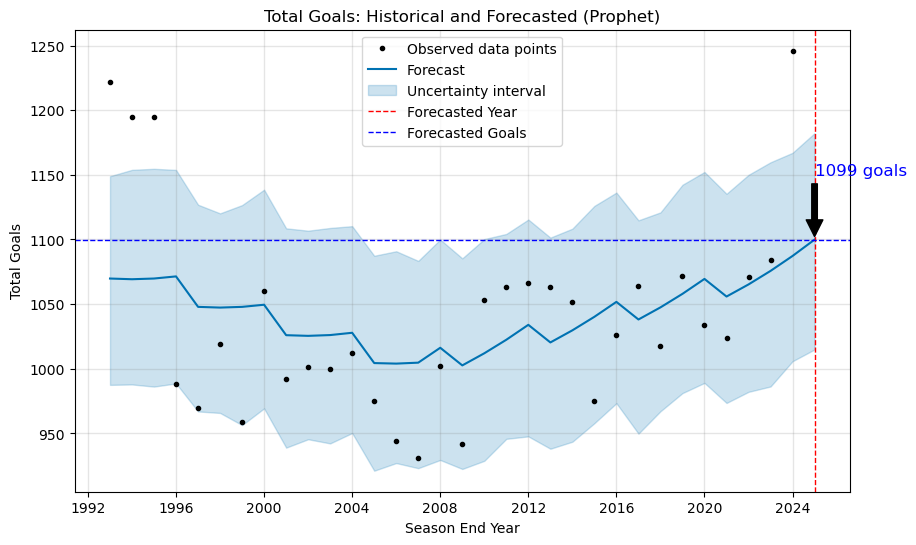

Prophet forecast for total goals in 2025: 1100


In [20]:
# Plot the forecast
fig, ax = plt.subplots(figsize=(10, 6))
model_prophet.plot(forecast_prophet, ax=ax)
plt.title('Total Goals: Historical and Forecasted (Prophet)')
plt.xlabel('Season End Year')
plt.ylabel('Total Goals')

# Highlight the forecasted points with vertical and horizontal lines
ax.axvline(x=future['ds'].iloc[-1], color='red', linestyle='--', linewidth=1, label='Forecasted Year')
ax.axhline(y=next_season_goals_prophet, color='blue', linestyle='--', linewidth=1, label='Forecasted Goals')

# Annotate the forecasted point
ax.annotate(f'{int(next_season_goals_prophet)} goals',
            xy=(future['ds'].iloc[-1], next_season_goals_prophet),
            xytext=(future['ds'].iloc[-1], next_season_goals_prophet + 50),
            arrowprops=dict(facecolor='black', shrink=0.05),
            fontsize=12, color='blue')

plt.legend()
plt.show()

# Print the forecasted total goals for the next season
next_season_year = df['Season_End_Year'].dt.year.max() + 1
print(f"Prophet forecast for total goals in {next_season_year}: {next_season_goals_prophet:.0f}")